# EDA Notebook
In this notebook we conduct exploratory data analysis to our dataset to better understand the nature of our data and insights for machine learning efforts.

In [2]:
import pandas as pd
data = pd.read_csv('../data/cleaned_data_v2.csv')

### Correlation of survey answers

sns heatmap

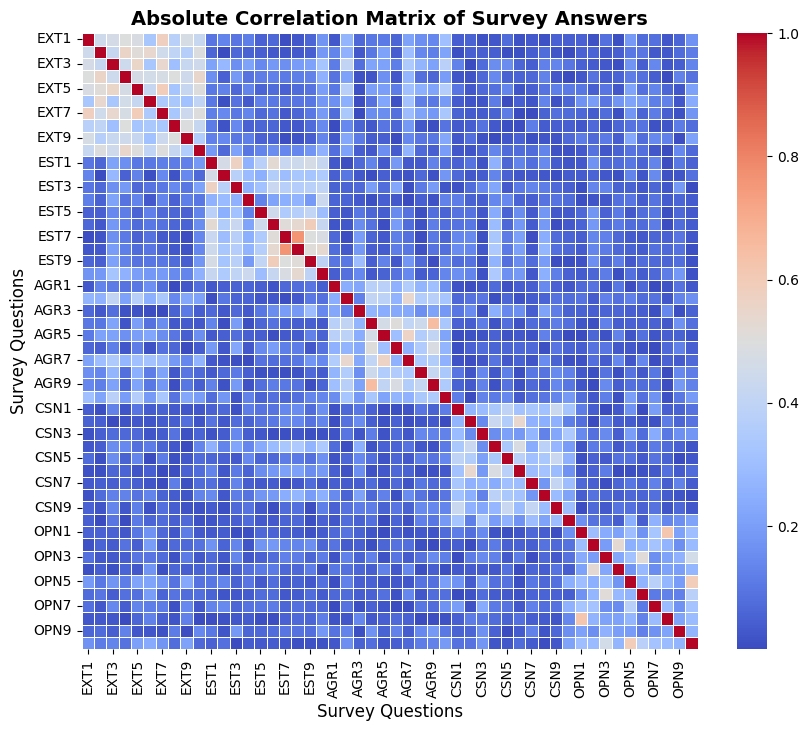

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load survey answer column names
survey_answer_cols = pd.read_excel('../scoring/scoring.xlsx')['id'].tolist()

# Compute correlation matrix and take absolute values
answer_matrix_corr = data[survey_answer_cols].corr().abs()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(answer_matrix_corr, cmap='coolwarm', linewidths=0.5, cbar=True, square=True)

# Add title and labels
plt.title("Absolute Correlation Matrix of Survey Answers", fontsize=14, fontweight='bold')
plt.xlabel("Survey Questions", fontsize=12)
plt.ylabel("Survey Questions", fontsize=12)

# Show plot
plt.show()


top correlations

In [7]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load scoring table
scoring = pd.read_excel('../scoring/scoring.xlsx')

# Create a mapping from column 'id' to 'trait'
trait_map = dict(zip(scoring['id'], scoring['trait']))

# Load survey answer column names
survey_answer_cols = scoring['id'].tolist()

# Compute absolute correlation matrix
answer_matrix_corr = data[survey_answer_cols].corr().abs()

# Extract upper triangle of the correlation matrix without the diagonal
corr_unstacked = answer_matrix_corr.where(np.triu(np.ones(answer_matrix_corr.shape), k=1).astype(bool))

# Convert to a DataFrame and reset index
corr_pairs = corr_unstacked.stack().reset_index()
corr_pairs.columns = ['col1', 'col2', 'correlation']

# Extract category (first 3 letters of column names)
corr_pairs['category1'] = corr_pairs['col1'].str[:3]
corr_pairs['category2'] = corr_pairs['col2'].str[:3]

# Map column names to trait names
corr_pairs['trait1'] = corr_pairs['col1'].map(trait_map)
corr_pairs['trait2'] = corr_pairs['col2'].map(trait_map)

# Split into same-category and different-category correlations
same_category = corr_pairs[corr_pairs['category1'] == corr_pairs['category2']]
diff_category = corr_pairs[corr_pairs['category1'] != corr_pairs['category2']]

# Get top 5 highest correlations in each category
top5_same = same_category.nlargest(5, 'correlation')
top5_diff = diff_category.nlargest(5, 'correlation')

# Add 'id' values for reference
top5_same['id1'] = top5_same['col1']
top5_same['id2'] = top5_same['col2']
top5_diff['id1'] = top5_diff['col1']
top5_diff['id2'] = top5_diff['col2']

# Select and rename columns for final display
columns = ['trait1', 'trait2', 'id1', 'id2', 'correlation']
top5_same = top5_same[columns].rename(columns={'trait1': 'Trait A', 'trait2': 'Trait B', 'id1': 'ID A', 'id2': 'ID B', 'correlation': 'Correlation'})
top5_diff = top5_diff[columns].rename(columns={'trait1': 'Trait A', 'trait2': 'Trait B', 'id1': 'ID A', 'id2': 'ID B', 'correlation': 'Correlation'})

# Print results in table format
print("\nTop 5 Correlations (Same Category):")
print(tabulate(top5_same, headers='keys', tablefmt='pretty', showindex=False))

print("\nTop 5 Correlations (Different Categories):")
print(tabulate(top5_diff, headers='keys', tablefmt='pretty', showindex=False))



Top 5 Correlations (Same Category):
+------------------------------------+------------------------------------------------+------+-------+--------------------+
|              Trait A               |                    Trait B                     | ID A | ID B  |    Correlation     |
+------------------------------------+------------------------------------------------+------+-------+--------------------+
|       I change my mood a lot       |          I have frequent mood swings           | EST7 | EST8  | 0.7624114483454573 |
| I sympathize with others' feelings |            I feel other's emotions             | AGR4 | AGR9  | 0.6491016599500528 |
|      I have a rich vocabulary      |             I use difficult words              | OPN1 | OPN8  | 0.6181919891370746 |
|       I have excellent ideas       |               I am full of ideas               | OPN5 | OPN10 | 0.5934627916500531 |
|       I start conversations        | I talk to a lot of different people at parties | EXT5 | 

### Distrbution of Trait Scores